# LLM TCG

## imports

In [1]:
import importlib
import ollama
from generate_image import ImageGenerator
import card_layers
import re
import os
from PIL import Image
import matplotlib.pyplot as plt
import json

c:\Users\jordy\Documents\python\projects\LLM_TCG\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading pipeline components...: 100%|██████████| 5/5 [00:00<00:00, 10.09it/s]


list of models available at the time on your computer<br>
use ```ollama run model_name``` in a command window to download the model weigths

In [2]:
for model in ollama.list()['models']:
    print(model['name'])

mixtral:8x7b
llama3.1:8b


## Create card database

In [3]:
prompt0 = """
I want to create a new Trading Card Game (TCG) with 3 families: Forest Humanoids, Animals, and Phantoms.
In each family there are two types of cards: characters (HP, defence, attack) and objects (special effects).
Cards mana goes from 1 to 5.
I want you to create the first character card of the forest_humanoids family.
json should look like this:
{
  "name": card_name,
  "family": family name,
  "type": "character",
  "mana": x,
  "HP": x,
  "defence": x,
  "attack": x
  "promtp": very detailed description of the card Artwork (do not use the name of the card), also describe the background (40 words excatly)
}
"""

response = ollama.chat(model='mixtral:8x7b', keep_alive=0, messages=[
  {
    'role': 'user',
    'content': prompt0
  },
])
r0 = response['message']['content']
# print(r0)
# Extract the JSON part from the text
json_start = r0.find('{')
json_end = r0.rfind('}') + 1
json_content = r0[json_start:json_end]
# Evaluate the JSON content to a variable
cards_db = [json.loads(json_content)]
print(cards_db)

[{'name': 'Elderwood Keeper', 'family': 'Forest Humanoids', 'type': 'character', 'mana': 3, 'HP': 12, 'defence': 5, 'attack': 6, 'prompt': 'A wise and ancient guardian of the forest stands tall amidst a lush grove of towering trees. Vines and moss cover his sturdy wooden staff, while his eyes hold the wisdom of countless seasons. A gentle stream flows through the idyllic background, reflecting the dappled sunlight filtering through the leaves above.'}]


In [4]:
def create_new_card(family, type):
  # family = 'Forest Humanoids'     # Animals, Phantoms
  # type = 'character'              # object
  if type == 'character':
    stat_or_effect = 'statistics'
    json_example = """
{
  "name": card_name,
  "family": family name,
  "type": "character",
  "mana": x,
  "HP": x,
  "defence": x,
  "attack": x
  "promtp": very detailed description of the card Artwork (do not use the name of the card), also describe the background (40 words excatly)
}
"""
  elif type == 'object':
    stat_or_effect = 'effects' 
    json_example = """
}
  "name": card_object_name,
  "family": family name,
  "type": "object",
  "mana": x,
  "effect": effect description, effect reflects family style (5 words maximum)
  "promtp": very detailed description of the card Artwork (do not use the name of the card), also describe the background, this must be an object (40 words excatly)
}
"""

  prompt = f"""
Your are the game designer of a Trading Card Game (TCG) with 3 families: Forest Humanoids, Animals, and Phantoms.
The list of the cards is:
{cards_db}
I want you to create a new {type} card for the {family} family.
You have to make sure that all {type} cards from one family does not share the same {stat_or_effect}.
You also have to make sure the mana repartition (1 to 5) is good between all cards from a family.
High mana cards should have more powerful {stat_or_effect} than low mana cards.
json should look like this:
{json_example}
"""

  response = ollama.chat(model='mixtral:8x7b', messages=[
    {
      'role': 'user',
      'content': prompt
    },
  ])
  r0 = response['message']['content']
  try:
    # Use regular expression to find the first JSON object
    match = re.search(r'\{.*?\}', r0, re.DOTALL)
    if match:
      json_content = match.group(0)
      json_content = json_content.replace("\": '", '": "')
      json_content = json_content.replace("',", '",')
      json_content = json_content.replace(".'", '."')
    else:
      print(f"⚠️ No JSON object found in the text:\n{r0}")
      return
    cards_db.append(json.loads(json_content))
  except:
    print(f'Error with te following response:\n{r0}\njson_content:\n{json_content}')
    return
  
  
  # print(cards_db)

In [6]:
db_to_produce = [
    # ('Forest Humanoids', 'character'),
    # ('Forest Humanoids', 'character'),
    # ('Forest Humanoids', 'object'),
    # ('Forest Humanoids', 'object'),
    # ('Animals', 'character'),
    # ('Animals', 'character'),
    # ('Animals', 'character'),
    ('Animals', 'object'),
    # ('Animals', 'object'),
    # ('Phantoms', 'character'),
    # ('Phantoms', 'character'),
    # ('Phantoms', 'character'),
    # ('Phantoms', 'object'),
    # ('Phantoms', 'object')
]
for fam, typ in db_to_produce:
    print(f'\n{fam} - {typ} ---------------')
    create_new_card(fam, typ)
    print([cards_db[-1]])


Animals - object ---------------
[{'name': 'Frostreach Tiger Pelt', 'family': 'Animals', 'type': 'object', 'mana': 3, 'effect': 'Enchant character, +1 attack, +1 dodge', 'prompt': "A magnificent and chilly tiger pelt, shimmering with frost. The pelt's intricate patterns of blue and white swirl like a winter storm, while its eyes seem to gaze into the distance. A snowy and icy tundra landscape serves as the backdrop, with tall snowdrifts and sparse trees under the starlit sky."}]


In [16]:
cards_db

[{'name': 'Elderwood Keeper',
  'family': 'Forest Humanoids',
  'type': 'character',
  'mana': 3,
  'HP': 12,
  'defence': 5,
  'attack': 6,
  'prompt': 'A wise and ancient guardian of the forest stands tall amidst a lush grove of towering trees. Vines and moss cover his sturdy wooden staff, while his eyes hold the wisdom of countless seasons. A gentle stream flows through the idyllic background, reflecting the dappled sunlight filtering through the leaves above.'},
 {'name': 'Dryad Songweaver',
  'family': 'Forest Humanoids',
  'type': 'character',
  'mana': 2,
  'HP': 8,
  'defence': 3,
  'attack': 4,
  'prompt': 'A graceful and enchanting dryad skillfully plucks at her harp, weaving a symphony of soothing melodies that resonate through the forest. The strings of her instrument emit gentle pulses of light, illuminating the verdant foliage around her. A cascading waterfall serves as the backdrop for this magical performance.'},
 {'name': 'Forest Sprite',
  'family': 'Forest Humanoids'

## Create lore and rules

In [ ]:
prompt = f"""
Your are the game designer of a Trading Card Game (TCG) with 3 families: Forest Humanoids, Animals, and Phantoms.
The list of the cards is:
{cards_db}
I want you to find a name for the game and a 200 words description of the lore.
"""

response = ollama.chat(model='mixtral:8x7b', messages=[
{
    'role': 'user',
    'content': prompt
},
])
r0 = response['message']['content']

In [18]:
print(r0)

 Game Name: "Shards of Gaia"

In the world of Shards of Gaia, ancient beings known as the Primal Forces shattered the sacred Crystal of Harmony, plunging the realm into chaos. The once unified land split into three distinct realms - the ethereal dominion of Phantoms, the lush habitats of Animals, and the mystical sanctuaries of Gaia's children, the Elementals.

The Primal Forces, in their quest for power, distorted the balance between these realms, causing an ever-growing imbalance that threatens to consume all life. To restore harmony, brave heroes from each realm must band together, harnessing the powers of their ancestors and uniting as one force against the chaos.

Embark on a journey across vast landscapes and through treacherous dungeons, collecting shards of the Crystal of Harmony to mend the rift between realms. Uncover hidden secrets and forge alliances with powerful beings, battling foes and restoring balance to Gaia. The fate of the world lies in your hands. Will you be the 

In [20]:
prompt2 = f"""
Based on the lore you just created, I want you to describe the cover of the game box.
"""

response = ollama.chat(model='mixtral:8x7b', messages=[
{
    'role': 'user',
    'content': prompt
},
{
    'role': 'assistant',
    'content': r0
},
{
    'role': 'user',
    'content': prompt2
},
])
r2 = response['message']['content']
print(r2)

 The cover of the "Shards of Gaia" game box showcases a breathtaking and vibrant landscape that encapsulates the essence of the realms in harmony. At the foreground, three heroes – an Animal summoner with a majestic tiger by their side, a Phantom mage holding a spectral staff, and a Gaian elementalist invoking a gust of wind – stand united, ready to embark on their quest to restore balance.

In the background, a once-shattered Crystal of Harmony is now partially mended, with shimmering beams of light connecting the three realms. The ethereal Phantom realm is depicted as an enchanting night sky filled with stars and swirling clouds. The Animal realm showcases a lush, verdant forest teeming with life, while the Gaian sanctuaries are represented by ancient stone structures enveloped in shimmering elemental energy.

The title "Shards of Gaia" is displayed prominently across the top, embellished with intricate, rune-like symbols that evoke a sense of history and mysticism. The tagline "Choo

In [23]:
prompt3 = f"""
Can you detail all the gameplay rules of the game ? Make something different from the usual TCG.
"""

response = ollama.chat(model='mixtral:8x7b', messages=[
{
    'role': 'user',
    'content': prompt
},
{
    'role': 'assistant',
    'content': r0
},
{
    'role': 'user',
    'content': prompt2
},
{
    'role': 'assistant',
    'content': r2
},
{
    'role': 'user',
    'content': prompt3
},
])
r3 = response['message']['content']
print(r3)

 Title: Shards of Gaia - A Realm Conflux Strategy Game

Objective: Players work together to restore balance and harmony between three realms by collecting shards, battling foes, and leveling up heroes while managing resources and making strategic decisions throughout the game.

Components:

1. Realm cards (Phantom, Animal, Gaia)
2. Hero cards (Summoner, Mage, Elementalist)
3. Creature cards (Animals, Phantoms, Elementals)
4. Relic cards
5. Enemy cards
6. Shard cards
7. Fate and Balance tokens
8. Resource dice
9. Realm Conflux board

Setup:
a. Place the Realm Conflux board on the table.
b. Shuffle each realm deck (Phantom, Animal, Gaia) and draw three cards from each to form a central marketplace.
c. Draw five cards from the enemy deck and place them face down near the board as encounters.
d. Randomly select three shard cards and place them near the board as objectives.
e. Each player selects one hero card, receives starting resources, and takes five cards from their respective realm's 

## AI image generation

this part is done with:
- generate_image.py<br>
the Flux.1 [dev] piece of code to generate images based on prompts
- card_layers.py<br>
adding layered informations to the card (HP, mana, ...)

### game box

In [22]:
ImGen = ImageGenerator()
game_box_prompt = "An old wooden table with 'Shards of Gaia' engraved on it with a game box representing a breathtaking and vibrant landscape that encapsulates the essence of the realms in harmony. At the foreground, three heroes – an Animal summoner with a majestic tiger by their side, a Phantom mage holding a spectral staff, and a Gaian elementalist invoking a gust of wind"
image = ImGen.generate_image(game_box_prompt, height=400, width=600)
card_img_path = f"out_images/game_box.png"
ImGen.save_image(image, card_img_path)
print(f'{card_img_path} created')

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to C:\Users\jordy\.cache\huggingface\token
Login successful


Loading pipeline components...: 100%|██████████| 7/7 [00:04<00:00,  1.72it/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (90 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['stand united, ready to embark on their quest to restore balance.']
100%|██████████| 25/25 [49:29<00:00, 118.77s/it]   


out_images/game_box.png created


### one card

In [7]:
ImGen = ImageGenerator()
image = ImGen.generate_image(cards_db[0]['prompt'])
# image = ImGen.generate_image(cards_db[0]['prompt'], height=352, width=256, guidance_scale=0.0, num_inference_steps=4, max_sequence_length=256)
card_img_path = f"out_images/{cards_db[0]['family']}_{cards_db[0]['type']}_{cards_db[0]['name']}.png"
ImGen.save_image(image, card_img_path)
print(f'{card_img_path} created')

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to C:\Users\jordy\.cache\huggingface\token
Login successful


100%|██████████| 25/25 [03:49<00:00,  9.19s/it]


out_images/Forest Humanoids_character_Elderwood Keeper.png created


### all cards

In [10]:
ImGen = ImageGenerator()
for card_dict in cards_db[:]:
    image = ImGen.generate_image(card_dict['prompt'] + '. Anime screencap style')
    card_img_path = f"out_images/{card_dict['family']}_{card_dict['type']}_{card_dict['name']}.png"
    ImGen.save_image(image, card_img_path)

    card_layers.add_layers_to_card(card_img_path, card_dict)


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to C:\Users\jordy\.cache\huggingface\token
Login successful


100%|██████████| 25/25 [01:46<00:00,  4.27s/it]
Token indices sequence length is longer than the specified maximum sequence length for this model (87 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["like the phantom's fingers.. anime screencap style"]
100%|██████████| 25/25 [01:51<00:00,  4.47s/it]


### plot the Set

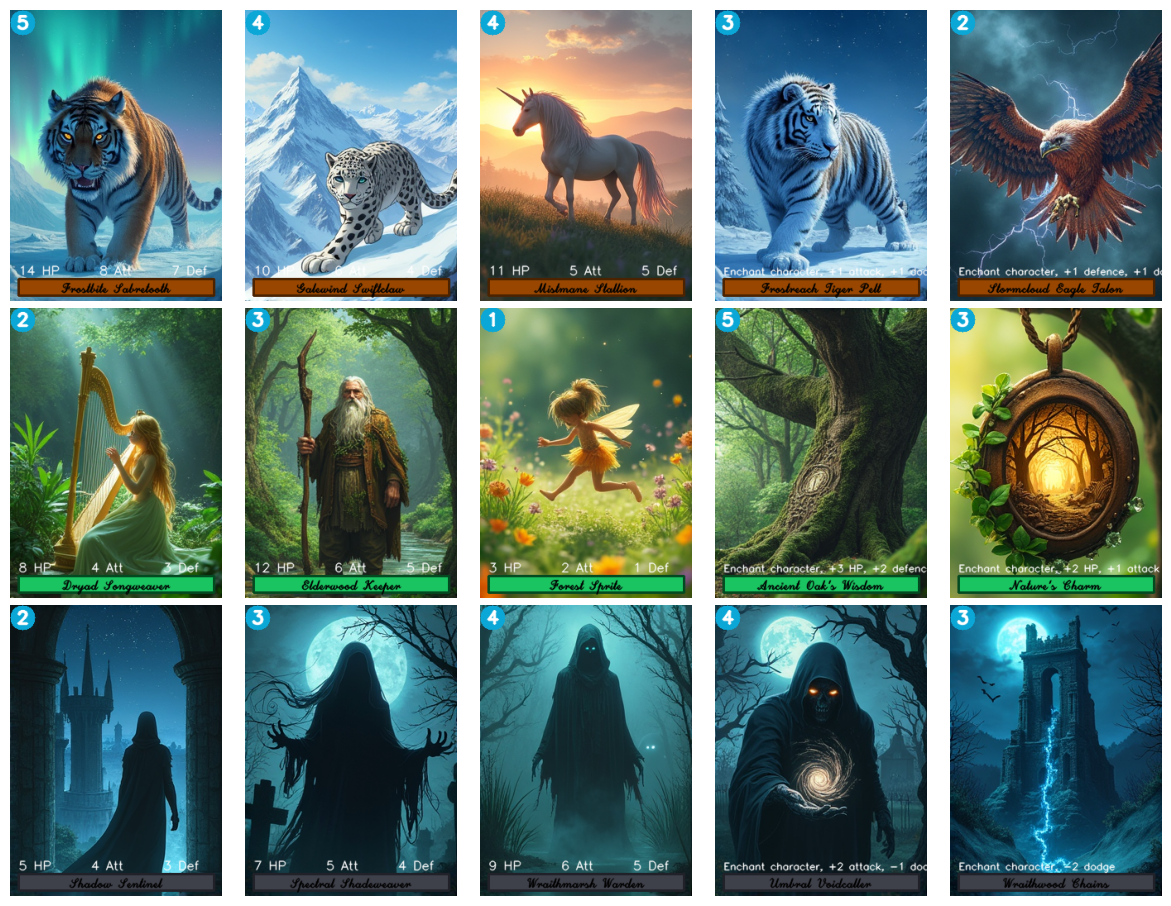

In [15]:
image_folder = 'out_images'
image_files = [f for f in os.listdir(image_folder) if 'layered' in f]

# Define the number of columns
num_cols = 5
num_images = len(image_files)
num_rows = (num_images + num_cols - 1) // num_cols  # Calculate the number of rows needed

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 3 * num_rows))

for i, image_file in enumerate(image_files):
    image_path = os.path.join(image_folder, image_file)
    image = Image.open(image_path)
    row = i // num_cols
    col = i % num_cols
    axes[row, col].imshow(image)
    axes[row, col].axis('off')

# Hide any unused subplots
for j in range(num_images, num_rows * num_cols):
    row = j // num_cols
    col = j % num_cols
    axes[row, col].axis('off')

# Adjust the spacing between subplots to remove margins
plt.subplots_adjust(wspace=0, hspace=0)

plt.tight_layout(pad=0.5)
plt.show()

### redo layering on images

In [9]:
importlib.reload(card_layers)
card_layers.add_layers_to_card(r'out_images\Forest Humanoids_character_Elderwood Keeper.png', cards_db[0])

In [ ]:
importlib.reload(card_layers)
for card_dict in cards_db[:]:
    print(card_dict['name'])
    
    card_img_path = f"out_images/{card_dict['family']}_{card_dict['type']}_{card_dict['name']}.png"

    card_layers.add_layers_to_card(card_img_path, card_dict)